# Exploring the Accidents Data Set of the Nairobi Ambulance Challenge <a name="Top"></a>

In this notebook we will look further into the Train.csv data set. It contains all accidents with time and location over 18 months between 01/2018 and 07/2019. Check out documentation at https://github.com/caiomiyashiro/geospatial_data_analysis/blob/master/AMLD-2020/Presentation_AMLD_2020.ipynb

## Table of Contents

[Imports and setup](#Imports_setup)<br>
[Extract, transform and load the data](#ETL)<br>
[Data analysis](#Data_analysis)<br>
[Data cleaning](#Data_cleaning)<br>
[Road segment info](#Road_segments)<br>
[Weather data](#Weather)<br>

</br>
</br>
</br>

## Imports and setup <a name="Imports_setup"></a>

### Importing packages

In [1]:
import pandas as pd
import datetime as dt
import holidays
import math
import seaborn as sns

### Setup

In [59]:
pd.set_option('display.max_columns', None)

[Back to top](#Top)<br>

</br>
</br>
</br>

## Extract, transform and load the data <a name="ETL"></a>

### Reading data

In [2]:
df_train = pd.read_csv('../Inputs/Train.csv', parse_dates=['datetime'])
print(df_train.shape)
df_train.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


### Extracting date informations and creating time windows

Extracting date, time, day, weekday, month and year out of the datetime.

In [3]:
df_train["date"] = df_train["datetime"].apply(lambda x: x.date())
df_train["time"] = df_train["datetime"].apply(lambda x: x.time())
df_train["day"] = df_train["datetime"].apply(lambda x: x.day)
df_train["weekday"] = df_train["datetime"].apply(lambda x: x.weekday())
df_train["weekend"] = df_train["weekday"].apply(lambda x: 1 if x>4 else 0)

dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
df_train["month"] = df_train["datetime"].apply(lambda x: dict_months.get(x.month))

df_train["year"] = df_train["datetime"].apply(lambda x: x.year)

df_train.head()

,uid,datetime,latitude,longitude,date,time,day,weekday,weekend,month,year
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,1,0,0,Jan,2018
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,1,0,0,Jan,2018
2,3,2018-01-01 02:31:49,-0.662939,37.208730,2018-01-01,02:31:49,1,0,0,Jan,2018
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,1,0,0,Jan,2018
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,1,0,0,Jan,2018


Creating time windows as demand containers / time window. This helps to interpret demand over time and will fit the submission format.

In [4]:
dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
df_train["time_window"] = df_train["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
df_train["time_window"] = df_train["time_window"].apply(lambda x: dict_windows.get(x))
df_train["datetime_window"] = df_train[["date", "time_window"]].apply(lambda x : f"{x[0]}_{x[1]}", axis=1)
df_train.head()

,uid,datetime,latitude,longitude,date,time,day,weekday,weekend,month,year,time_window,datetime_window
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,1,0,0,Jan,2018,00-03,2018-01-01_00-03
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,1,0,0,Jan,2018,00-03,2018-01-01_00-03
2,3,2018-01-01 02:31:49,-0.662939,37.208730,2018-01-01,02:31:49,1,0,0,Jan,2018,00-03,2018-01-01_00-03
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,1,0,0,Jan,2018,03-06,2018-01-01_03-06
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,1,0,0,Jan,2018,03-06,2018-01-01_03-06


### Creating time windows without accidents

In [5]:
print(df_train["datetime"].min())
print(df_train["datetime"].max())
print(df_train["datetime"].max() - df_train["datetime"].min())

2018-01-01 00:25:46
2019-06-30 20:06:14
545 days 19:40:28


In [6]:
date_list = pd.date_range(df_train["date"].min(), periods=546).tolist()
window_list = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-24"]
datetime_window_list = []
for day in date_list:
    for time_window in window_list:
        datetime_window_list.append(str(day.date()) + "_" + time_window)

In [46]:
# Print all the holidays in Kenya in year 2018 
for holiday in holidays.Kenya(years = 2018).items(): 
    print(holiday)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 5, 1), 'Labour Day')
(datetime.date(2018, 6, 1), 'Madaraka Day')
(datetime.date(2018, 10, 20), 'Mashujaa Day')
(datetime.date(2018, 12, 12), 'Jamhuri (Independence) Day')
(datetime.date(2018, 12, 25), 'Christmas Day')
(datetime.date(2018, 12, 26), 'Boxing Day')
(datetime.date(2018, 3, 30), 'Good Friday')
(datetime.date(2018, 4, 2), 'Easter Monday')


In [193]:
# Creating dataframe from window_list
df_complete = pd.DataFrame(datetime_window_list, columns=["datetime_window"])


# Counting accidents per time window and leftjoin to complete dataframe
acc_count = df_train.groupby("datetime_window").count()["uid"].reset_index()
df_complete = df_complete.merge(acc_count[["datetime_window", "uid"]], on="datetime_window", how='left')
df_complete.rename(columns={"uid":"accidents"}, inplace=True)


# Creating new data frame with split value columns
new = df_complete["datetime_window"].str.split("_", n=1, expand=True)

# Adding date column to complete dataframe from new data frame
df_complete["date"]= new[0].astype('datetime64[ns]')

# Adding time_window column to complete dataframe from new data frame
df_complete["time_window"]= new[1]

# Adding day of month
df_complete["day"] = df_complete["date"].apply(lambda x: x.day)

# Adding weekday
df_complete["weekday"] = df_complete["date"].apply(lambda x: x.weekday())

# Adding 1 for weekend days and 0 for working days
df_complete["weekend"] = df_complete["weekday"].apply(lambda x: 1 if x>4 else 0)

# Adding month
df_complete["month"] = df_complete["date"].apply(lambda x: dict_months.get(x.month))

# Adding year
df_complete["year"] = df_complete["date"].apply(lambda x: x.year)

# Adding holidays
df_complete["holiday"] = df_complete["date"].apply(lambda x: 1 if (x in holidays.Kenya()) else 0)

# Adding rainy / flood season (https://en.wikipedia.org/wiki/Nairobi#Climate)
rainy_season = ["Mar", "Apr", "May", "Oct", "Nov", "Dec"]
df_complete["rainy_season"] = df_complete["month"].apply(lambda x: 1 if (x in rainy_season) else 0)



# Adding min for latitude and longitude
l_min = df_train.groupby("datetime_window")[["latitude", "longitude"]].min().reset_index()
df_complete = df_complete.merge(l_min[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
df_complete.rename(columns={"latitude":"latitude_min", "longitude":"longitude_min"}, inplace=True)

# Adding max for latitude and longitude
l_max = df_train.groupby("datetime_window")[["latitude", "longitude"]].max().reset_index()
df_complete = df_complete.merge(l_max[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
df_complete.rename(columns={"latitude":"latitude_max", "longitude":"longitude_max"}, inplace=True)

# Adding spread for latitude and longitude
df_complete["latitude_spread"] = df_complete["latitude_max"] - df_complete["latitude_min"]
df_complete["longitude_spread"] = df_complete["longitude_max"] - df_complete["longitude_min"]

# Adding median for latitude and longitude
l_median = df_train.groupby("datetime_window")[["latitude", "longitude"]].median().reset_index()
df_complete = df_complete.merge(l_median[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
df_complete.rename(columns={"latitude":"latitude_median", "longitude":"longitude_median"}, inplace=True)

# Adding mean for latitude and longitude
l_mean = df_train.groupby("datetime_window")[["latitude", "longitude"]].mean().reset_index()
df_complete = df_complete.merge(l_mean[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
df_complete.rename(columns={"latitude":"latitude_mean", "longitude":"longitude_mean"}, inplace=True)

# Adding standard deviation for latitude and longitude
l_std = df_train.groupby("datetime_window")[["latitude", "longitude"]].std().reset_index()
df_complete = df_complete.merge(l_std[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
df_complete.rename(columns={"latitude":"latitude_std", "longitude":"longitude_std"}, inplace=True)



# Filling NaNs with zeros
df_complete.fillna(value=0, inplace=True)

# Changing type to integer
df_complete["accidents"] = df_complete["accidents"].astype("int")

# Printing head
df_complete.tail(30)

,datetime_window,accidents,date,time_window,day,weekday,weekend,month,year,holiday,rainy_season,latitude_min,longitude_min,latitude_max,longitude_max,latitude_spread,longitude_spread,latitude_median,longitude_median,latitude_mean,longitude_mean,latitude_std,longitude_std
4338,2019-06-27_06-09,6,2019-06-27,06-09,27,3,0,Jun,2019,0,0,-1.335833,36.718516,-1.233802,36.873170,0.102031,0.154654,-1.280302,36.807369,-1.282572,36.807932,0.037615,0.058612
4339,2019-06-27_09-12,1,2019-06-27,09-12,27,3,0,Jun,2019,0,0,-1.324186,36.890361,-1.324186,36.890361,0.000000,0.000000,-1.324186,36.890361,-1.324186,36.890361,0.000000,0.000000
4340,2019-06-27_12-15,2,2019-06-27,12-15,27,3,0,Jun,2019,0,0,-1.300013,36.787803,-1.240642,36.844184,0.059371,0.056382,-1.270328,36.815993,-1.270328,36.815993,0.041982,0.039868
4341,2019-06-27_15-18,0,2019-06-27,15-18,27,3,0,Jun,2019,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4342,2019-06-27_18-21,1,2019-06-27,18-21,27,3,0,Jun,2019,0,0,-1.290127,36.821148,-1.290127,36.821148,0.000000,0.000000,-1.290127,36.821148,-1.290127,36.821148,0.000000,0.000000
4343,2019-06-27_21-24,2,2019-06-27,21-24,27,3,0,Jun,2019,0,0,-1.529032,36.766556,-1.342968,37.126661,0.186064,0.360105,-1.436000,36.946608,-1.436000,36.946608,0.131567,0.254633
4344,2019-06-28_00-03,0,2019-06-28,00-03,28,4,0,Jun,2019,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4345,2019-06-28_03-06,0,2019-06-28,03-06,28,4,0,Jun,2019,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4346,2019-06-28_06-09,6,2019-06-28,06-09,28,4,0,Jun,2019,0,0,-1.331113,36.822385,-1.280635,36.888818,0.050478,0.066432,-1.325387,36.848139,-1.313936,36.849722,0.022207,0.025340
4347,2019-06-28_09-12,2,2019-06-28,09-12,28,4,0,Jun,2019,0,0,-2.100000,36.750000,-1.364663,36.911642,0.735337,0.161642,-1.732332,36.830821,-1.732332,36.830821,0.519962,0.114298


In [200]:
df_complete.groupby("time_window").sum("accidents")["accidents"]

time_window
00-03     296
03-06     340
06-09    1724
09-12     976
12-15     834
15-18     853
18-21     888
21-24     407
Name: accidents, dtype: int64

In [9]:
df_complete[df_complete["accidents"] == 0].groupby("time_window").count()["date"]

time_window
00-03    432
03-06    389
06-09    142
09-12    183
12-15    208
15-18    171
18-21    222
21-24    314
Name: date, dtype: int64

[Back to top](#Top)<br>

</br>
</br>
</br>

## Data analysis <a name="Data_analysis"></a>

### Plotting time_windows for different periods of time

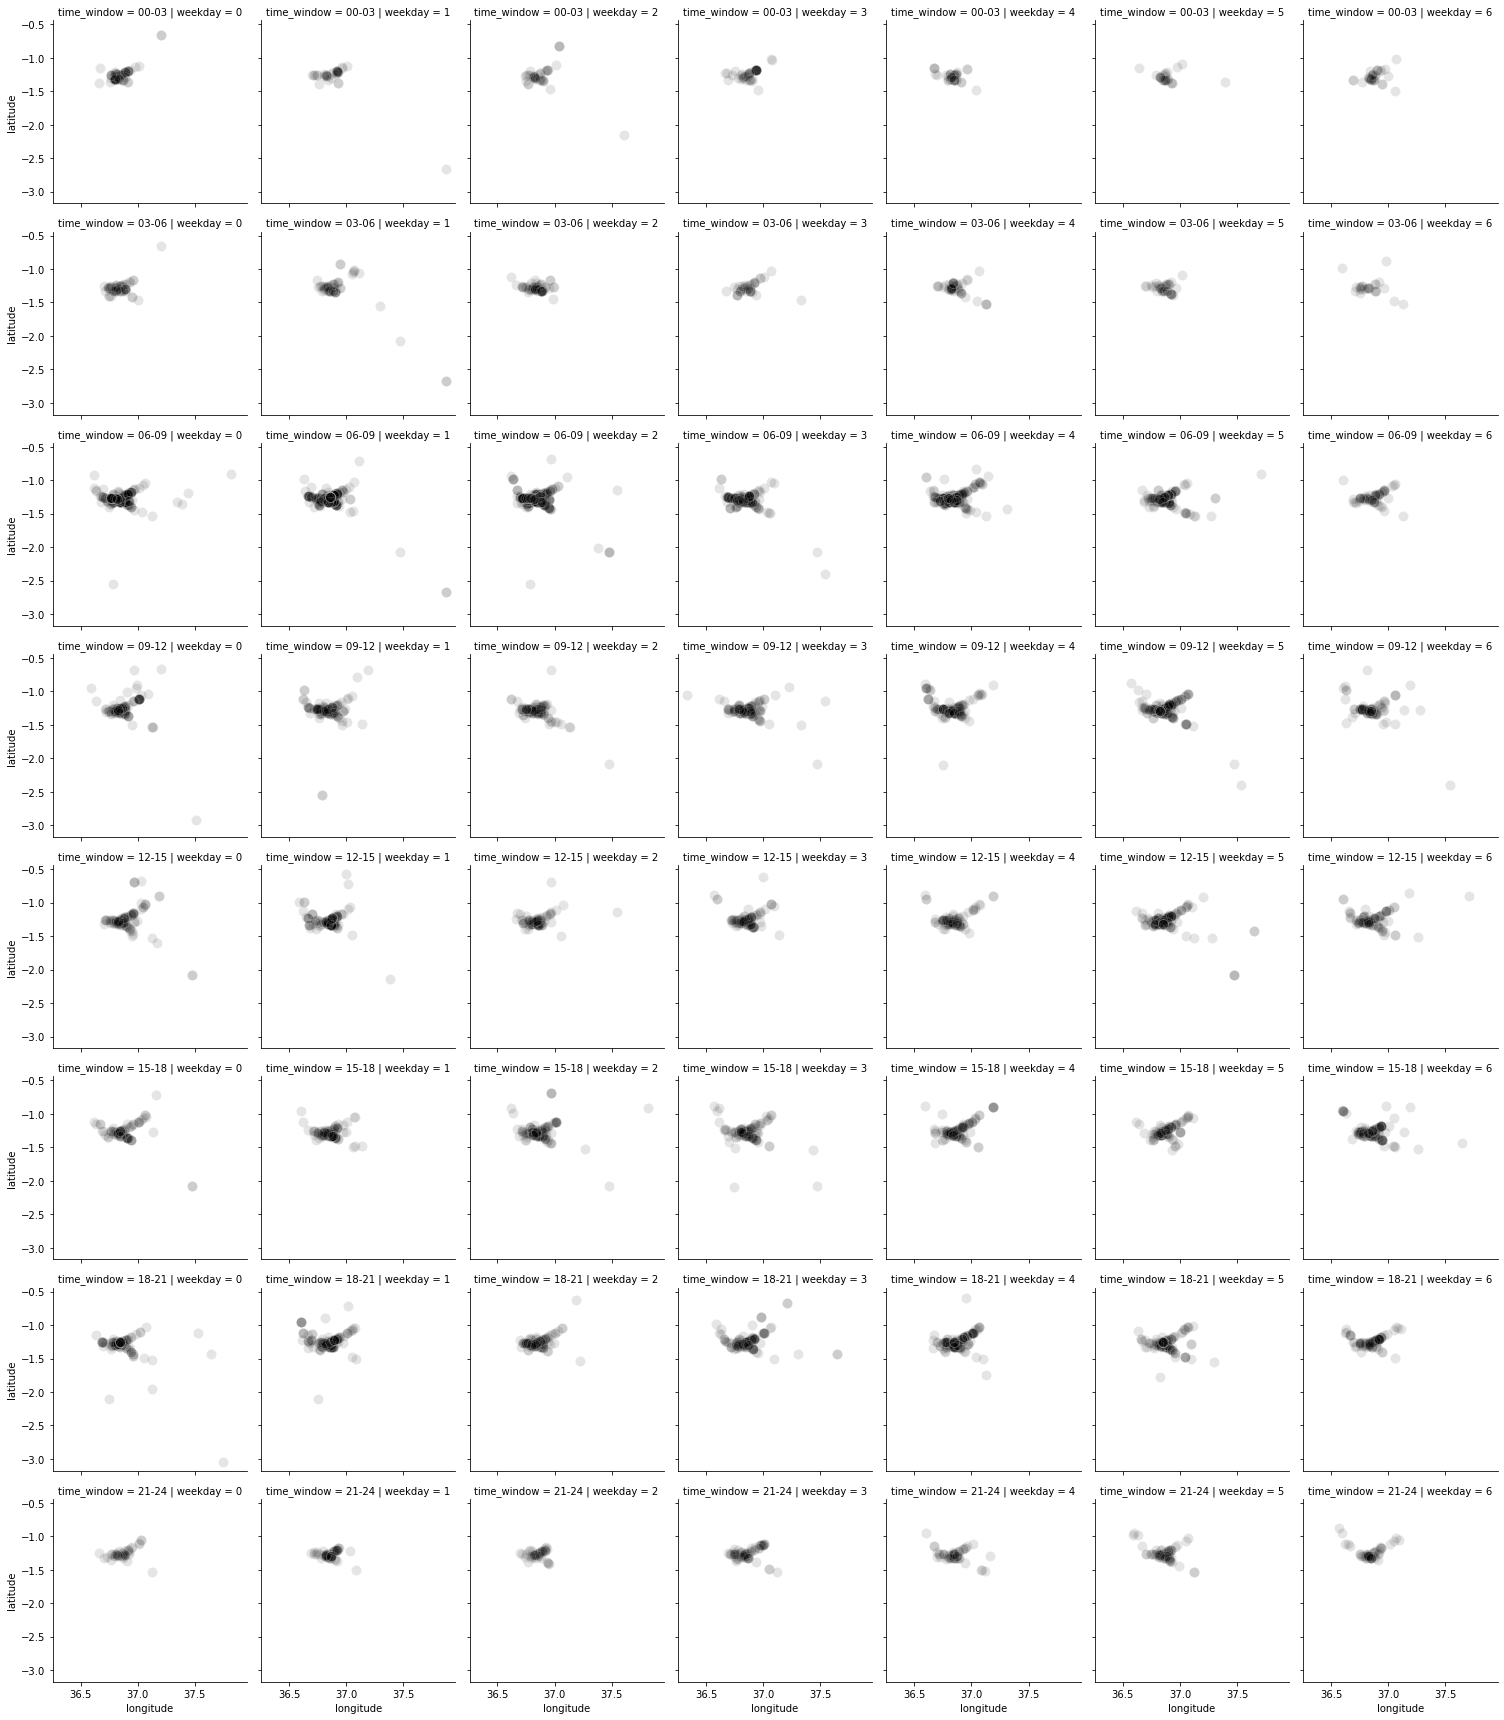

In [10]:
g_tw_wd = sns.FacetGrid(df_train, col="weekday", row="time_window");
g_tw_wd.map(sns.scatterplot, "longitude", "latitude", color="k", s=100, alpha=0.1);

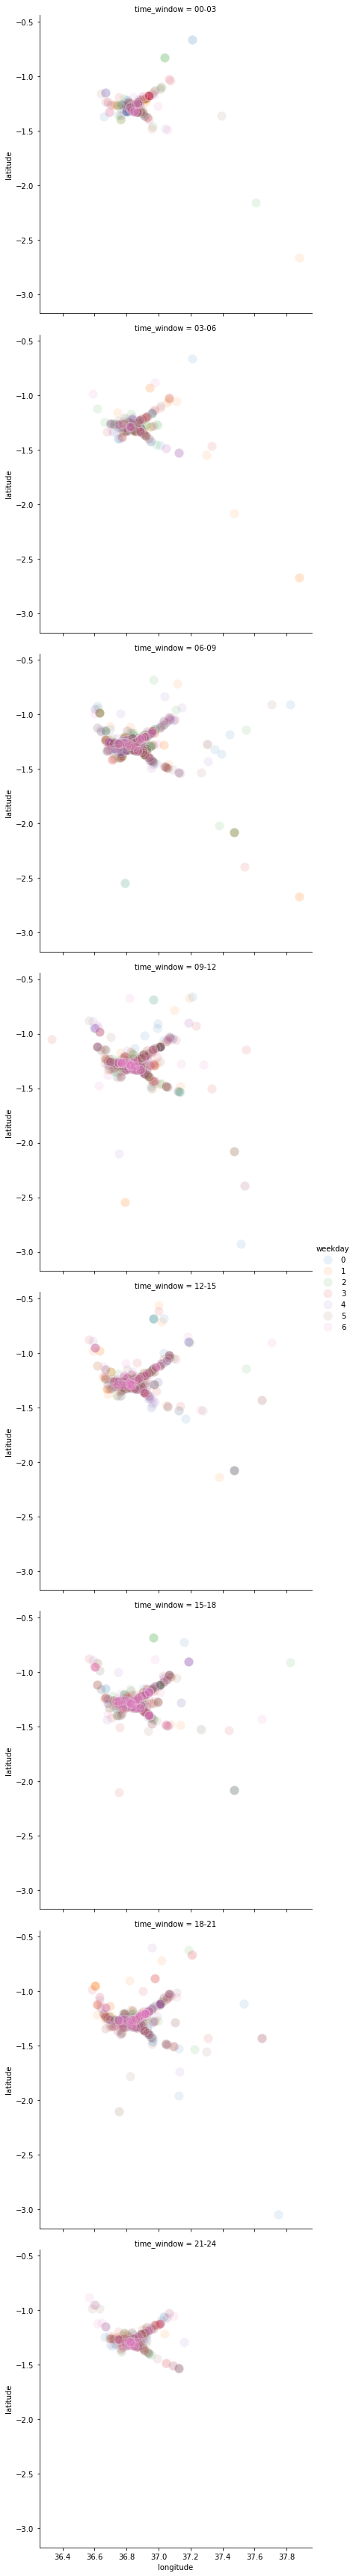

In [11]:
g_tw_wd = sns.FacetGrid(df_train, hue="weekday", row="time_window", height=6, aspect=1);
g_tw_wd.map(sns.scatterplot, "longitude", "latitude", s=150, alpha=0.1);
g_tw_wd.add_legend();

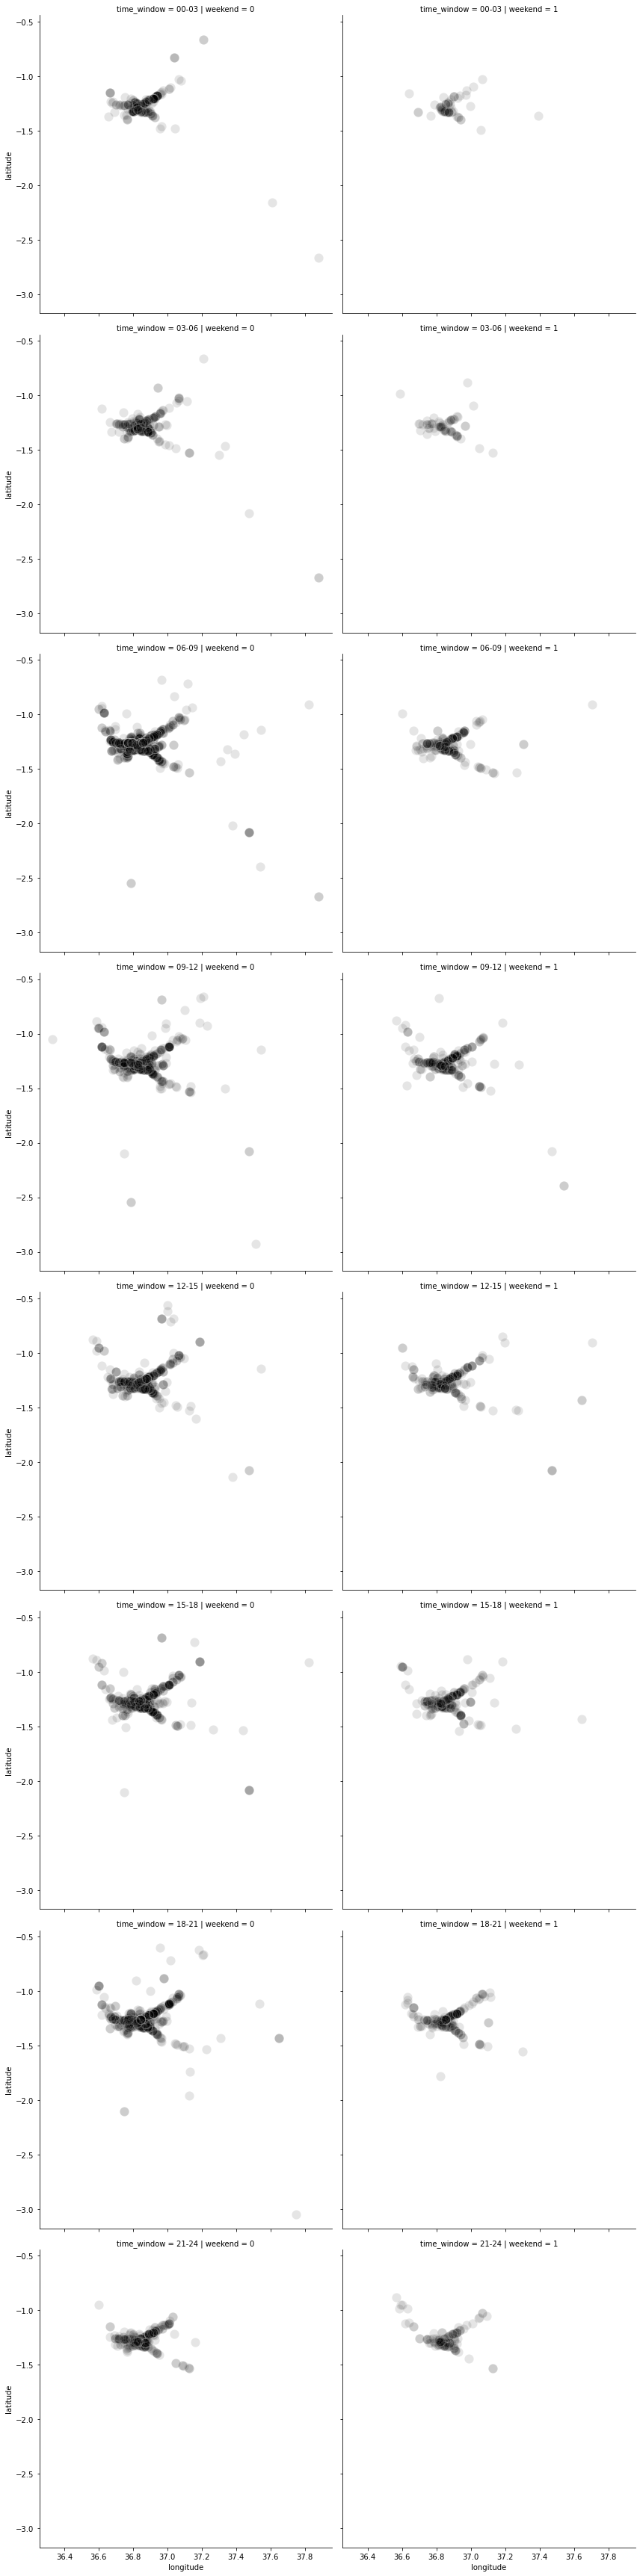

In [12]:
g_tw_wd = sns.FacetGrid(df_train, col="weekend", row="time_window", height=6, aspect=1);
g_tw_wd.map(sns.scatterplot, "longitude", "latitude", color="k", s=150, alpha=0.1);

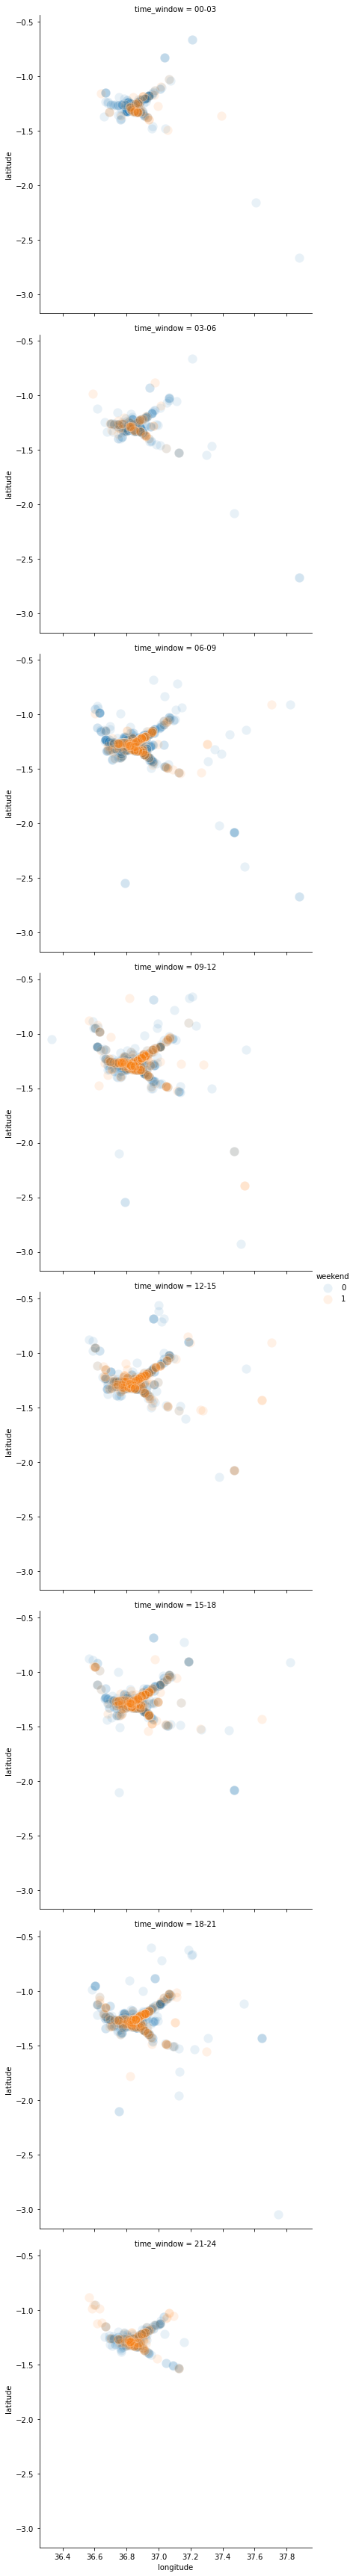

In [13]:
g_tw_wd = sns.FacetGrid(df_train, hue="weekend", row="time_window", height=6, aspect=1);
g_tw_wd.map(sns.scatterplot, "longitude", "latitude", s=150, alpha=0.1);
g_tw_wd.add_legend();

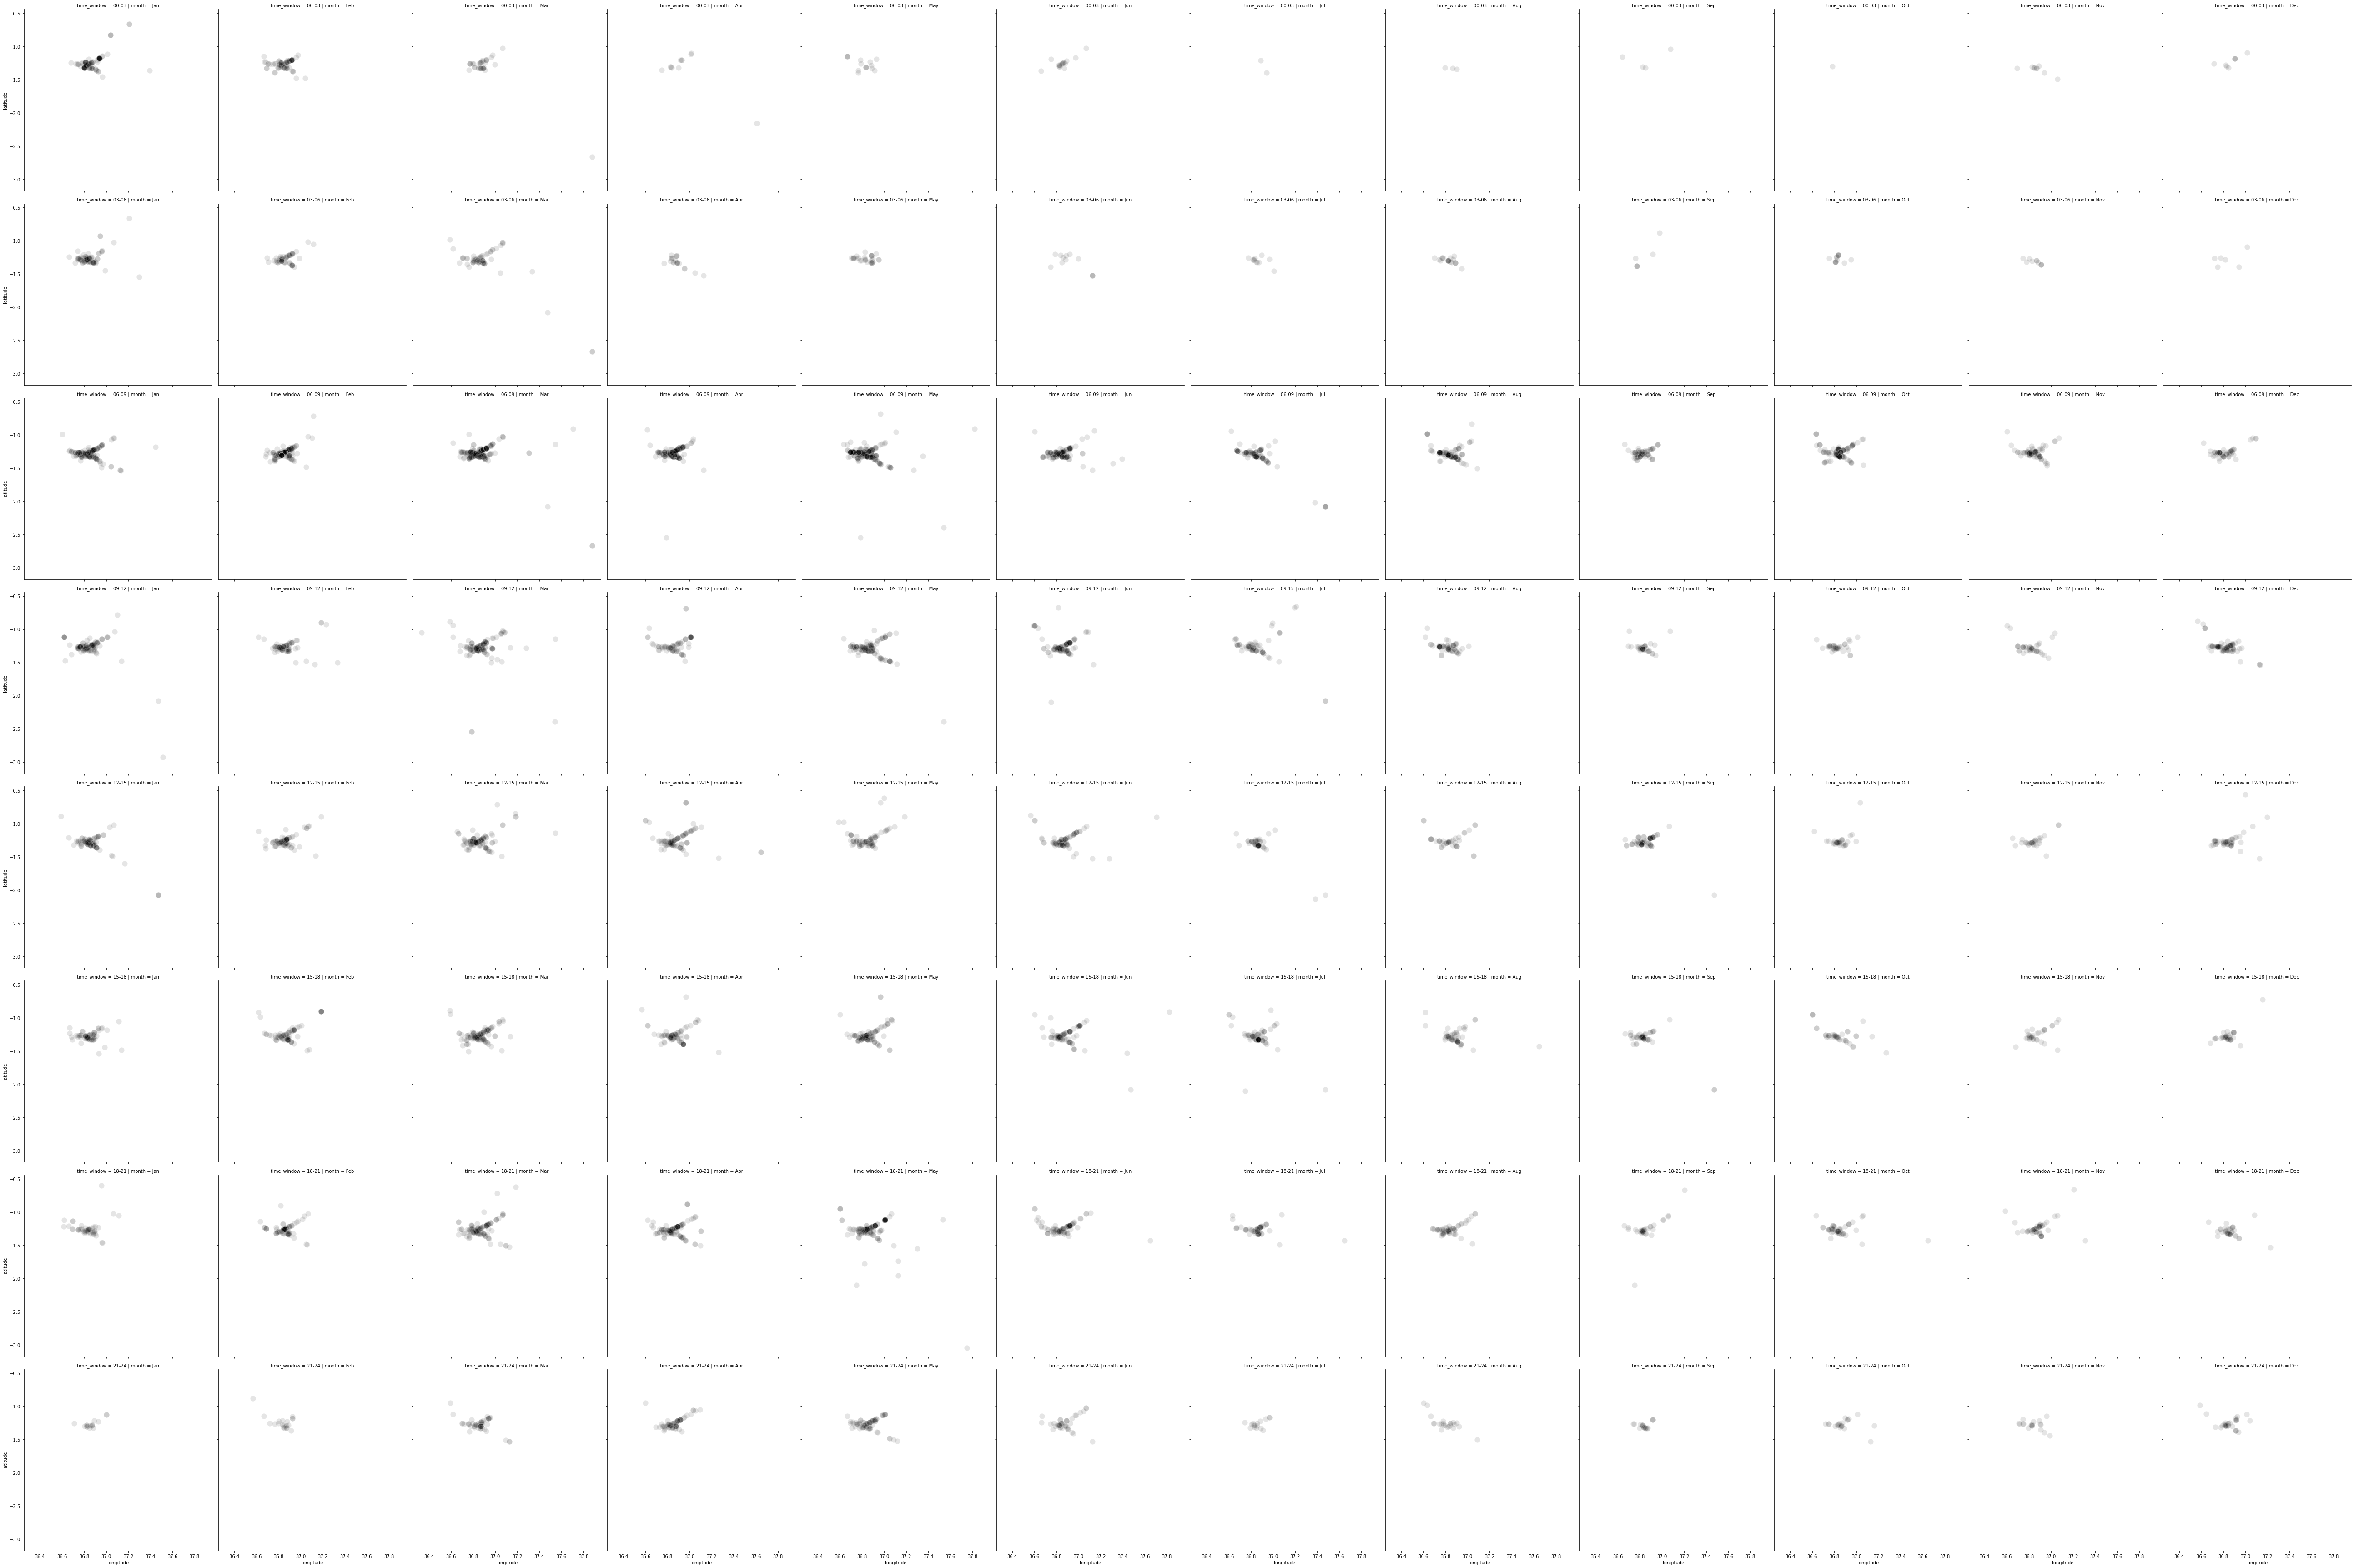

In [14]:
g_tw_wd = sns.FacetGrid(df_train, col="month", row="time_window", height=6, aspect=1);
g_tw_wd.map(sns.scatterplot, "longitude", "latitude", color="k", s=150, alpha=0.1);

### Overall accidents per time window for 2018 and 2019

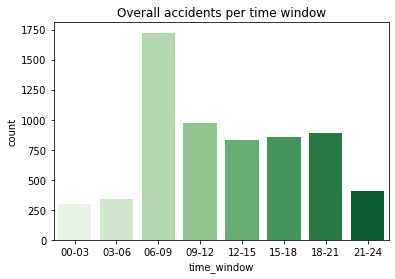

In [15]:
fig01 = sns.countplot(data=df_train, x="time_window", palette="Greens")
fig01.set_title("Overall accidents per time window");

### Mean and median accidents per time window for 2018 and 2019

In [16]:
max_acc = pd.crosstab(df_train["time_window"], df_train["day"]).max(axis=1)
min_acc = pd.crosstab(df_train["time_window"], df_train["day"]).min(axis=1)
mean_acc = pd.crosstab(df_train["time_window"], df_train["day"]).mean(axis=1)
median_acc = pd.crosstab(df_train["time_window"], df_train["day"]).median(axis=1)

In [17]:
df_stats = pd.DataFrame([max_acc, min_acc, mean_acc, median_acc]).T
df_stats.columns = ["max", "min", "mean", "median"]
df_stats.reset_index(inplace=True)
df_stats.head()

,time_window,max,min,mean,median
0,00-03,24.0,1.0,9.548387,8.0
1,03-06,36.0,1.0,10.967742,9.0
2,06-09,86.0,12.0,55.612903,58.0
3,09-12,57.0,12.0,31.483871,29.0
4,12-15,48.0,10.0,26.903226,27.0


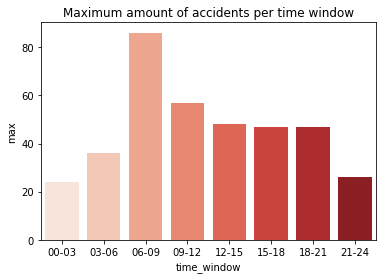

In [18]:
fig = sns.barplot(data=df_stats, x="time_window", y="max", palette="Reds")
fig.set_title("Maximum amount of accidents per time window");

Note: Minimum cannot be 0 because then we also do not have a column ... need to fix that somehow

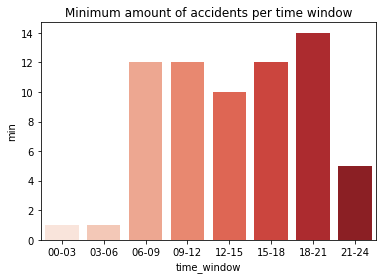

In [19]:
fig = sns.barplot(data=df_stats, x="time_window", y="min", palette="Reds")
fig.set_title("Minimum amount of accidents per time window");

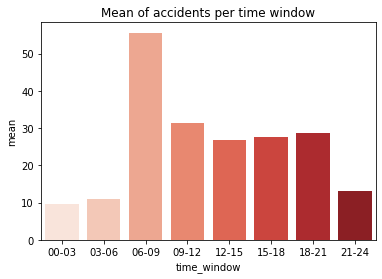

In [20]:
fig = sns.barplot(data=df_stats, x="time_window", y="mean", palette="Reds")
fig.set_title("Mean of accidents per time window");

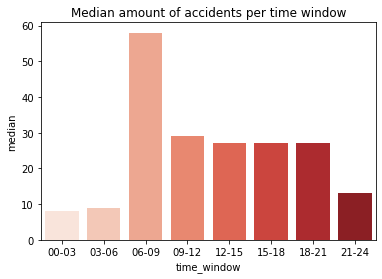

In [21]:
fig = sns.barplot(data=df_stats, x="time_window", y="median", palette="Reds")
fig.set_title("Median amount of accidents per time window");

### Overall accidents per month for 2018

Note: Avoid counting both first halfs (2018 & 2019)

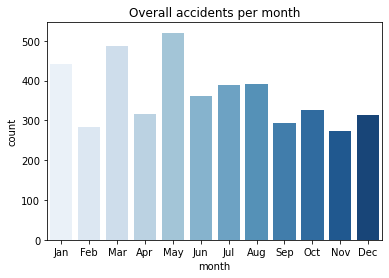

In [22]:
fig02 = sns.countplot(data=df_train[df_train.year == 2018], x="month", palette="Blues")
fig02.set_title("Overall accidents per month");

### Accidents per weekday

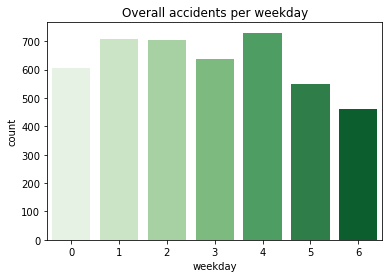

In [23]:
fig03 = sns.countplot(data=df_train[df_train.year == 2018], x="weekday", palette="Greens")
fig03.set_title("Overall accidents per weekday");

### Time window per day

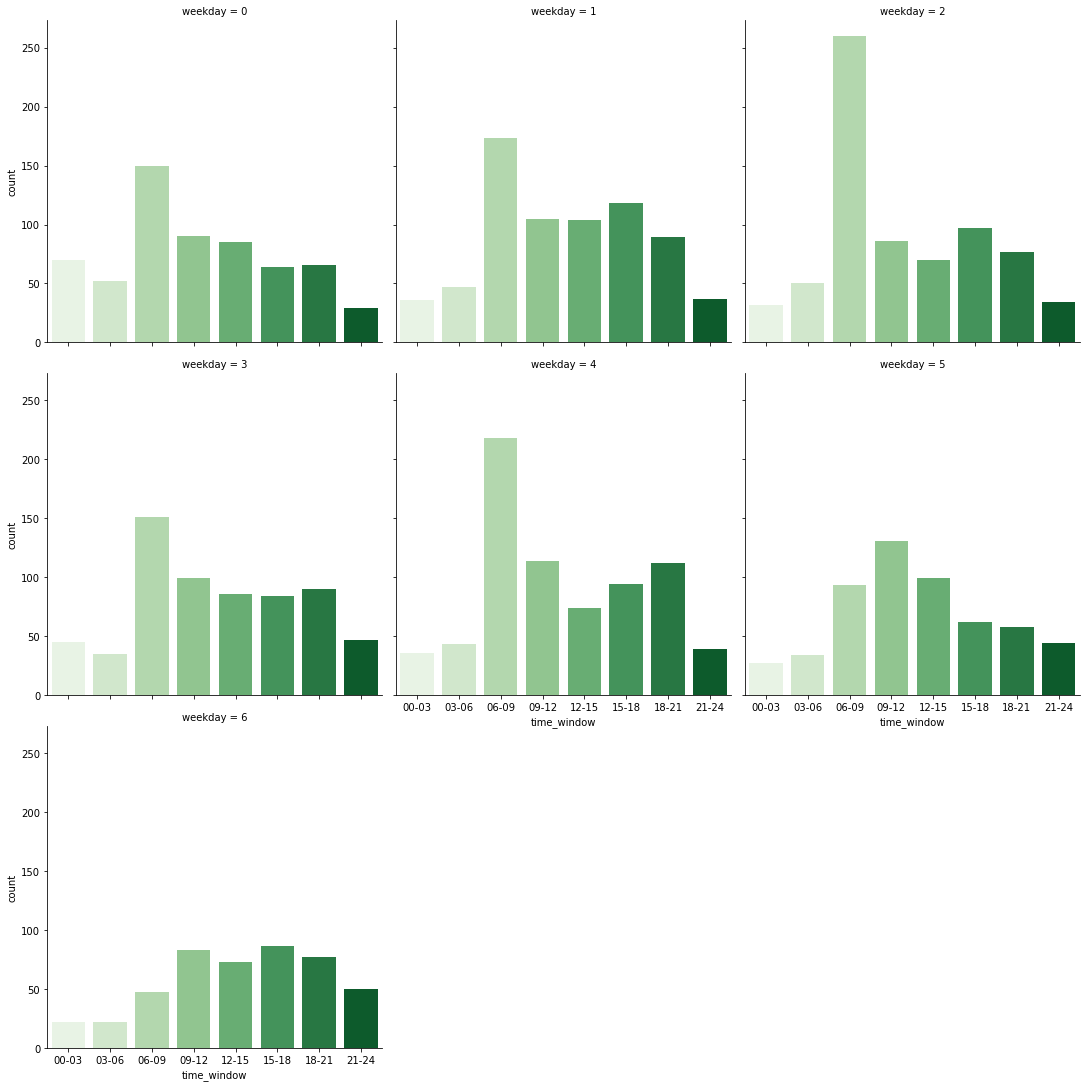

In [24]:
sns.catplot(x="time_window", col="weekday",data=df_train[df_train.year == 2018], kind="count", col_wrap=3, palette="Greens");

### Overall accidents per month and time window for 2018

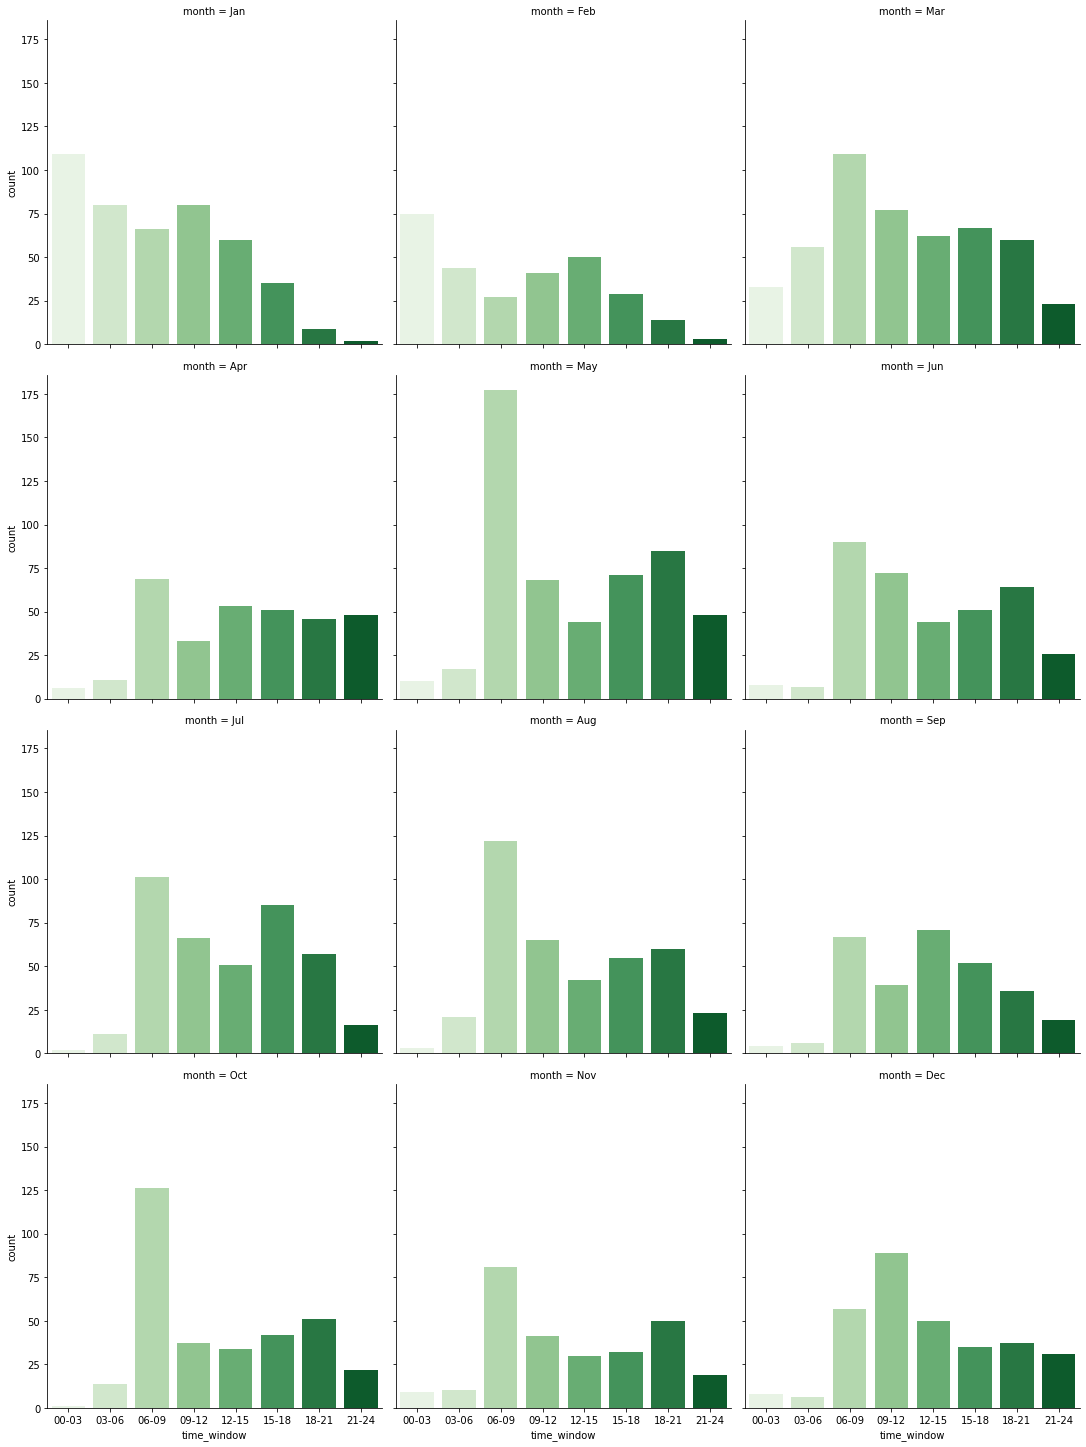

In [25]:
sns.catplot(x="time_window", col="month",data=df_train[df_train.year == 2018], kind="count", col_wrap=3, palette="Greens");

### Overall accidents per month and day for 2018

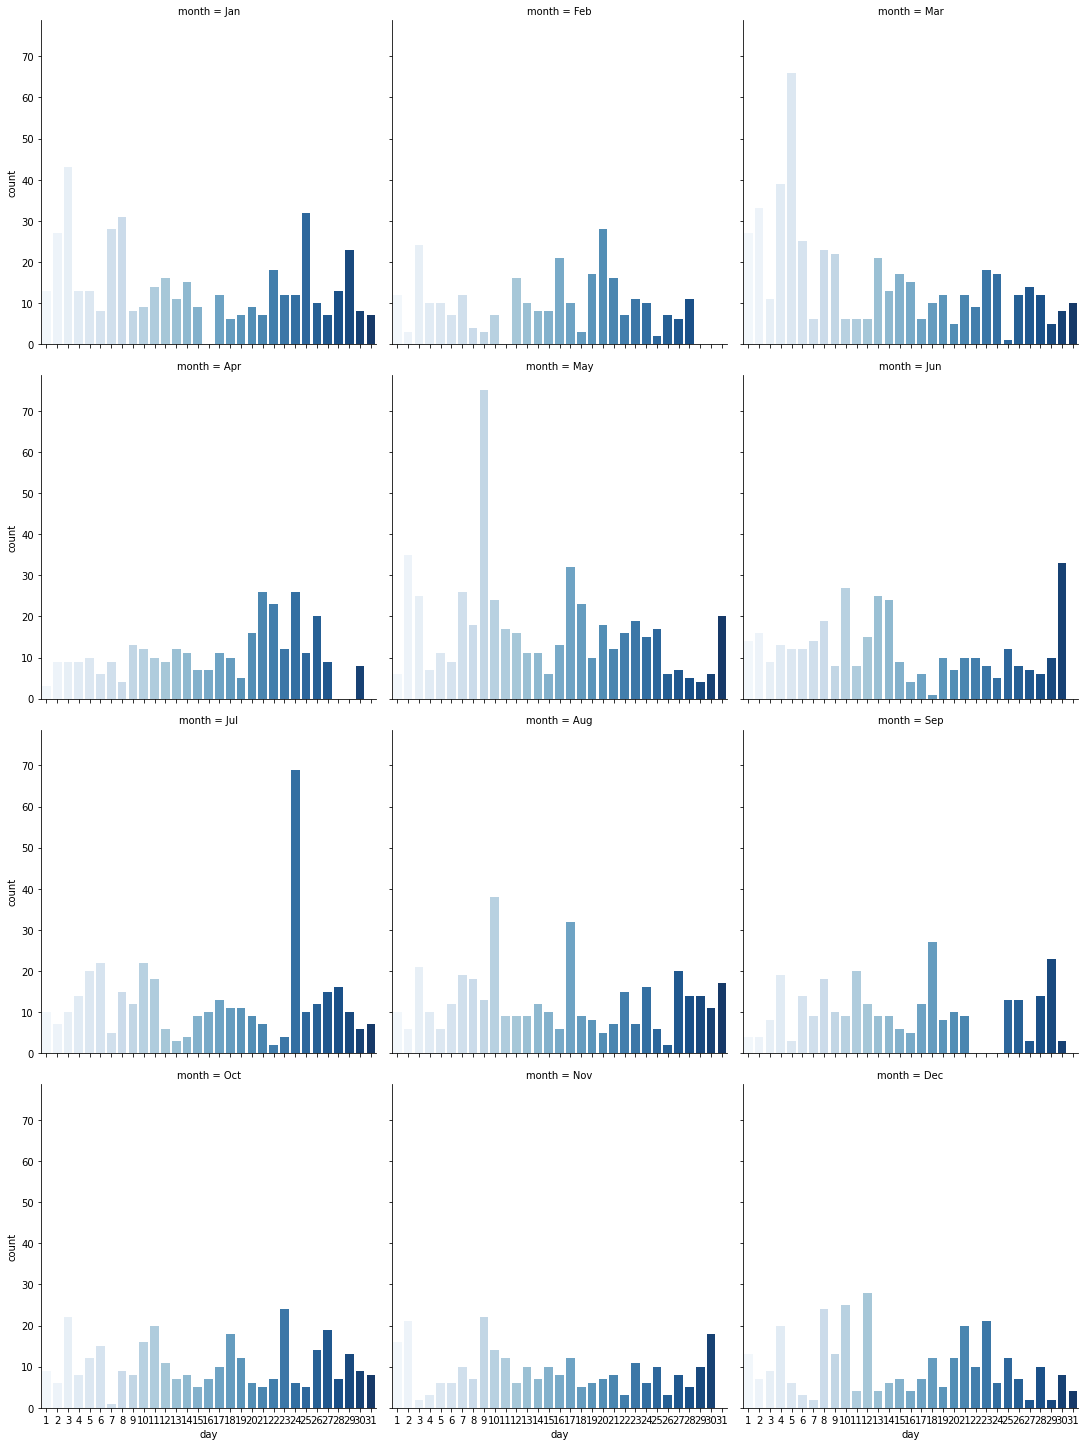

In [26]:
sns.catplot(x="day", col="month",data=df_train[df_train.year == 2018], kind="count", col_wrap=3, palette="Blues");

Note: **It seems that we have missing data for some days.**

In [27]:
df_check = df_train[(df_train.month == "Sep") & (df_train.day > 20) & (df_train.day < 26)]
df_check

,uid,datetime,latitude,longitude,date,time,day,weekday,weekend,month,year,time_window,datetime_window
3406,3407,2018-09-21 06:02:39,-1.213003,36.903414,2018-09-21,06:02:39,21,4,0,Sep,2018,06-09,2018-09-21_06-09
3407,3408,2018-09-21 06:09:09,-1.218637,36.891361,2018-09-21,06:09:09,21,4,0,Sep,2018,06-09,2018-09-21_06-09
3408,3409,2018-09-21 06:47:09,-1.289358,36.810835,2018-09-21,06:47:09,21,4,0,Sep,2018,06-09,2018-09-21_06-09
3409,3410,2018-09-21 09:40:39,-1.329686,36.870994,2018-09-21,09:40:39,21,4,0,Sep,2018,09-12,2018-09-21_09-12
3410,3411,2018-09-21 18:14:39,-1.258831,36.915564,2018-09-21,18:14:39,21,4,0,Sep,2018,18-21,2018-09-21_18-21
3411,3412,2018-09-21 18:22:39,-1.299459,36.824866,2018-09-21,18:22:39,21,4,0,Sep,2018,18-21,2018-09-21_18-21
3412,3413,2018-09-21 19:04:39,-1.316585,36.833825,2018-09-21,19:04:39,21,4,0,Sep,2018,18-21,2018-09-21_18-21
3413,3414,2018-09-21 19:13:09,-1.316142,36.813828,2018-09-21,19:13:09,21,4,0,Sep,2018,18-21,2018-09-21_18-21
3414,3415,2018-09-21 21:26:09,-1.330251,36.866555,2018-09-21,21:26:09,21,4,0,Sep,2018,21-24,2018-09-21_21-24
3415,3416,2018-09-25 12:46:39,-1.205573,36.917440,2018-09-25,12:46:39,25,1,0,Sep,2018,12-15,2018-09-25_12-15


In [28]:
df_check.shape

(22, 13)

[Back to top](#Top)<br>

</br>
</br>
</br>

## Data cleaning <a name="Data_cleaning"></a>

In [194]:
days = df_complete.groupby("date").sum()["accidents"].reset_index()
days[days["accidents"] == 0]["date"]

15    2018-01-16
41    2018-02-11
117   2018-04-28
118   2018-04-29
264   2018-09-22
265   2018-09-23
266   2018-09-24
391   2019-01-27
Name: date, dtype: datetime64[ns]

In [201]:
def clean_train_data(data, how, on):
    '''
    Fills all time_windows of days without any accident with mean or median value of group of other days.
    how:
      mean
      median
    on:
      year = all days of the same year
      month = all days of the same month
      weekday = all same weekdays of the year
      holiday = if holiday all holidays of the year, if not all not-holidays
    '''
    
    days = df_complete.groupby("date").sum()["accidents"].reset_index()
    no_accidents = days[days["accidents"] == 0]["date"]
    
    for day in no_accidents:
        if how == "median":
            base = data.groupby(["time_window", on]).median().reset_index()
        elif how == "mean":
            base = data.groupby(["time_window", on]).mean().reset_index()
        print(base)
        
        for time_window in dict_windows:
            if on == "year":
                value = base.loc[(base["year"] == day.year) & (base["time_window"] == dict_windows[time_window]), ["accidents"]].values
            elif on == "month":
                value = base.loc[(base["month"] == day.month) & (base["time_window"] == dict_windows[time_window]), ["accidents"]].values
            elif on == "weekday":
                value = base.loc[(base["weekday"] == day.weekday) & (base["time_window"] == dict_windows[time_window]), ["accidents"]].values
            elif on == "holiday":
                #value = base.loc[(base["holiday"] == day.month) & (base["time_window"] == dict_windows[time_window]), ["accidents"]].values
                pass
                
            data.loc[(data["date"] == day) & (data["time_window"] == dict_windows[time_window]), ["accidents"]] = value
            
    return data

In [202]:
df_complete2 = clean_train_data(data = df_complete, how = "median", on = "year")
days2 = df_complete2.groupby("date").sum()["accidents"].reset_index()
days2[days2["accidents"] == 0]

   time_window  year  accidents  day  weekday  weekend  holiday  rainy_season  \
0        00-03  2018          0   16        3        0        0             1   
1        00-03  2019          0   16        3        0        0             1   
2        03-06  2018          0   16        3        0        0             1   
3        03-06  2019          0   16        3        0        0             1   
4        06-09  2018          2   16        3        0        0             1   
5        06-09  2019          2   16        3        0        0             1   
6        09-12  2018          1   16        3        0        0             1   
7        09-12  2019          1   16        3        0        0             1   
8        12-15  2018          1   16        3        0        0             1   
9        12-15  2019          1   16        3        0        0             1   
10       15-18  2018          1   16        3        0        0             1   
11       15-18  2019        

,date,accidents


[Back to top](#Top)<br>

</br>
</br>
</br>

## Road segment info <a name="Road_segments"></a>

In [29]:
df_seg_info = pd.read_csv('../Inputs/Segment_info.csv')
print(df_seg_info.shape)
df_seg_info.head()

(1535, 228)


,segment_id,side,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,...,80_97_61_65_11,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16
0,176_2,1,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,176_2,2,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,95_1,1,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95_1,2,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144_7,1,1,0,4,3,0.0,5,0,3,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


[Back to top](#Top)<br>

</br>
</br>
</br>

## Weather data <a name="Weather"></a>

In [30]:
df_weather = pd.read_csv('../Inputs/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
print(df_weather.shape)
df_weather.head()

(731, 7)


,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


In [51]:
df_weather[(df_weather["Date"] >= "2018-03-01") & (df_weather["Date"] <= "2018-03-31")]

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
59,2018-03-01,32.299999,72.500748,0.011270,17.748132,0.798853,-0.790566
60,2018-03-02,29.900000,80.883316,0.011100,15.822656,3.478000,1.068921
61,2018-03-03,31.088001,80.040787,0.011920,17.097131,0.114993,-0.018396
62,2018-03-04,31.564886,82.599998,0.011875,16.512262,1.862275,0.211370
63,2018-03-05,27.500000,77.200005,0.010749,16.056329,-0.551118,-1.117839
64,2018-03-06,28.200001,76.447960,0.010520,15.880945,-0.294949,-0.824487
65,2018-03-07,27.400000,87.577446,0.011470,15.111963,-0.553198,-0.346067
66,2018-03-08,21.748890,86.037735,0.011810,15.805017,-1.262422,-1.576135
67,2018-03-09,25.813440,69.500000,0.010340,17.037378,-1.553608,-1.876357
68,2018-03-10,29.513014,77.090630,0.011590,17.229456,-1.155603,-0.629778


In [55]:
df_complete[(df_complete["date"] >= "2018-03-06") & (df_complete["date"] <= "2018-03-16")]

,datetime_window,accidents,date,time_window,day,weekday,weekend,holiday,latitude_min,longitude_min,latitude_max,longitude_max,latitude_spread,longitude_spread,latitude_median,longitude_median,latitude_mean,longitude_mean,latitude_std,longitude_std
512,2018-03-06_00-03,1,2018-03-06,00-03,6,1,0,0,-1.245199,36.908200,-1.245199,36.908200,0.000000,0.000000,-1.245199,36.908200,-1.245199,36.908200,0.000000,0.000000
513,2018-03-06_03-06,5,2018-03-06,03-06,6,1,0,0,-1.345364,36.807375,-1.271076,36.902632,0.074288,0.095257,-1.344389,36.902475,-1.326124,36.872649,0.031891,0.043444
514,2018-03-06_06-09,2,2018-03-06,06-09,6,1,0,0,-1.344389,36.787803,-1.300013,36.902632,0.044375,0.114830,-1.322201,36.845217,-1.322201,36.845217,0.031378,0.081197
515,2018-03-06_09-12,3,2018-03-06,09-12,6,1,0,0,-1.345364,36.866803,-1.244702,36.902632,0.100662,0.035829,-1.344389,36.902475,-1.311485,36.890637,0.057838,0.020640
516,2018-03-06_12-15,4,2018-03-06,12-15,6,1,0,0,-1.356041,36.762077,-0.716670,37.016670,0.639371,0.254594,-1.298495,36.887105,-1.167425,36.888239,0.301725,0.103946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2018-03-16_09-12,2,2018-03-16,09-12,16,4,0,0,-1.283693,36.824870,-1.244703,36.867595,0.038990,0.042726,-1.264198,36.846233,-1.264198,36.846233,0.027570,0.030212
596,2018-03-16_12-15,1,2018-03-16,12-15,16,4,0,0,-1.291168,36.814402,-1.291168,36.814402,0.000000,0.000000,-1.291168,36.814402,-1.291168,36.814402,0.000000,0.000000
597,2018-03-16_15-18,0,2018-03-16,15-18,16,4,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
598,2018-03-16_18-21,5,2018-03-16,18-21,16,4,0,0,-1.342889,36.666389,-1.256155,36.967671,0.086734,0.301282,-1.278788,36.845518,-1.295897,36.825605,0.036314,0.109378


[Back to top](#Top)<br>